# Erdős-Rényi and Watts-Strogatz models

In [1]:
import networkx as nx;
import numpy as np;
import matplotlib.pyplot as plt;
import scipy.stats;
import amath;

## Erdős-Rényi model
 
Naturally, the Networkx package has a random graph generator implemented that is generating random graphs according to the classical Erdős-Rényi approach.

Let us first try it out with a small E-R graph!

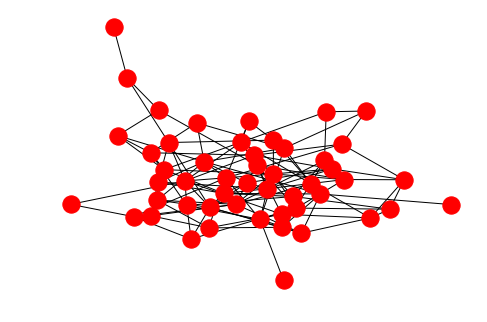

In [5]:
ER_graph = nx.generators.erdos_renyi_graph(50,0.1); # 1st argument is N, the 2nd argument is p
nx.draw(ER_graph)

As a simple excercise, let us prepare a figure similar to that in the lecture slides, where we plot the degree distribution for single instances of E-R graphs with the same average degree but different $N$.


To do so, we are going to use numpy for preparing the empirical degree distribution of the generated samples, and scipy for preparing the theoretical curve, given by a Poisson distribution.

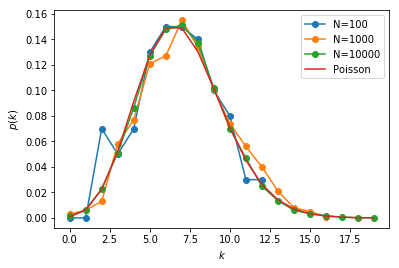

In [3]:
# firtst we define the 'parameters', namely the average degree and the sizes of the E-R graphs:
average_degree = 7;
ER_net_sizes = [100,1000,10000];

# next we generate the graphs, then measure and plot the p(k) for each:
ER_nets = [nx.generators.erdos_renyi_graph(N,average_degree/(N-1)) for N in ER_net_sizes]; # a list of E-R graphs
for net in ER_nets:     
    k_list = [net.degree(node) for node in net.nodes];                         # the list of node degrees,
    k_hist,k_bins = np.histogram(k_list,range(0,max(k_list)+1),density=True); # the normed. hist. for the degree,
    plt.plot(k_bins[:-1],k_hist,'-o',label = 'N='+str(net.number_of_nodes())); # and the plot of the histogram.
plt.xlabel('$k$');
plt.ylabel('$p(k)$');

# for the theoretical p(k) we need to somehow define a degree range, within which we would like to plot 
# the function. A simple choice is [0,k_max], where k_max is the largest degree occurring in any of the
# generated graphs.
k_max = 0;
for net in ER_nets:
    net_max_k = max([net.degree(node) for node in net.nodes]);
    if net_max_k > k_max:
        k_max = net_max_k;
# OK, now we can prepare the theoretical curve as well.
poisson_k = range(0,k_max);
poisson_p_k = [scipy.stats.poisson.pmf(k,average_degree) for k in poisson_k]
plt.plot(poisson_k,poisson_p_k,'-', label = 'Poisson');
plt.legend();
plt.show();    

Of course, we can get a more smooth $p(k)$ also from E-R graphs of size $N=100$ if we take more samples, and average the degree distribution over these samples. 

In technical terms, probably the most easy way to carry out this is to simply callect all degrees across all samples in just a single list, and prepare a $p(k)$ from that.  

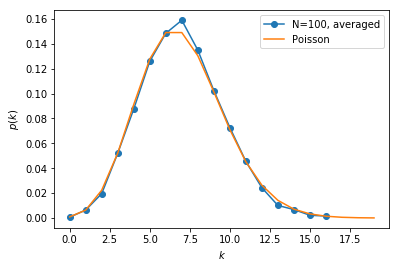

In [4]:
net_size,num_samples = 100,100;
aggregated_deg_list = [];
aggregated_deg_list.clear();
for i in range(0,num_samples):
    ER_net = nx.generators.erdos_renyi_graph(net_size,average_degree/(net_size-1));
    for node in ER_net.nodes:
        aggregated_deg_list.append(ER_net.degree(node));
k_hist,k_bins = np.histogram(aggregated_deg_list,range(0,max(aggregated_deg_list)+1),density=True);
plt.plot(k_bins[:-1],k_hist,'-o', label = 'N='+str(net_size)+', averaged');
plt.plot(poisson_k,poisson_p_k,'-', label = 'Poisson');
plt.xlabel('$k$');
plt.ylabel('$p(k)$');
plt.legend();
plt.show();   

## Watts-Strogatz model

The Watts-Strogatz model is also a built in function in Networkx. First, let us just try it out with a small network size:

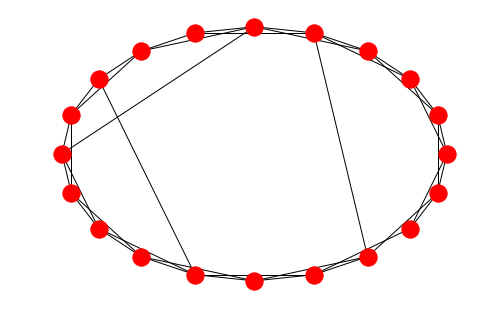

In [5]:
WS_graph = nx.generators.watts_strogatz_graph(20,4,0.05); # 1st argument: N, 2nd argument: 2q, 3rd argument: beta
nx.draw_circular(WS_graph)

Next, let us have a go at reproducing the main result of the Watts-Storgatz paper, namely the figure showing the different decay of $\left< \ell\right>$ and $\left< C\right>$ as a function of $\beta$.

Before actually starting to code, 2 important remarks:
- in the figure the horisontal axis showing $\beta$ was logarithmic,
- we have actually a simple estimate for the $\beta_c$ value, where the average distance is expected to start decaying in the form of $\beta_c qN=1$.

Based on these, a natural choice for the $\beta$ interval in which we would like to examine (and plot) $\left< \ell\right>$ and $\left< C\right>$ is something like $[\frac{\beta_c}{a},\beta_c\cdot a]$, where $a$ is a constant factor. This interval on a logarithmic scale looks to be centered on $\beta_c$. 

Since we are going to use a logarithmic scale for $\beta$, it would be also nice if the actually chosen $\beta$ values would look equidistant. Thus, we first define a function that returns a list of $\beta$ values between $\frac{\beta_c}{a}$ and $\beta\cdot a$ with a predefined number of points that look equidistant on a logarithmic $\beta$ scale:

In [6]:
def Beta_list_prepare(net_size,q_param,num_betas,factor_a):
    _beta_list = [];
    _beta_c = 1.0/(q_param*net_size);
    _log_beta_c = math.log(_beta_c);
    _log_min = math.log(_beta_c/factor_a);
    _log_max = math.log(_beta_c*factor_a);
    _log_x_below = np.arange(_log_min,_log_beta_c,(_log_beta_c-_log_min)/num_betas);
    _log_x_above = np.arange(_log_beta_c,_log_max,(_log_max-_log_beta_c)/num_betas);
    _x_list = [math.exp(_x) for _x in _log_x_below];
    for _x in _log_x_above:
        _x_list.append(math.exp(_x));
    return _x_list;

Let's just try it out:

In [8]:
try_betas = Beta_list_prepare(100,2,10,20);
print(try_betas);

[0.00025, 0.00033732071191839083, 0.00045514105075652, 0.0006141140130578952, 0.0008286135043349966, 0.0011180339887498945, 0.0015085440841362903, 0.002035452657684521, 0.002746401358265293, 0.0037056722455347368, 0.005000000000000002, 0.006746414238367819, 0.009102821015130404, 0.012282280261157907, 0.016572270086699935, 0.022360679774997897, 0.030170881682725817, 0.04070905315369044, 0.054928027165305884, 0.07411344491069476]


OK, now we are ready to generate W-S graphs with the same $N$ and $q$, but different $\beta$ parameter, and examine the dependence of $\left< \ell\right>$ and $\left< C\right>$ on $\beta$.

In [10]:
N,q_param,num_samples = 300,2,10;               # N,q, and the number of samples at each beta
beta_list = Beta_list_prepare(N,q_param,15,150) # we prepare the list of betas.
av_l,av_clust = [],[];                          # we are going to store l and C in these lists. 
av_l.clear();
av_clust.clear();
for beta in beta_list:
    print('beta = ',beta);
    WS_nets = [nx.generators.watts_strogatz_graph(N,2*q_param,beta) for i in range(0,num_samples)]; # W-S graphs
    l_list = [nx.average_shortest_path_length(net) for net in WS_nets];   # the l values measured      
    c_list = [nx.average_clustering(net) for net in WS_nets];             # the C values measured
    av_l.append(np.mean(l_list));            # we can use numpy to calculate the average
    av_clust.append(np.mean(c_list));

beta =  1.1111111111111115e-05
beta =  1.5517803250385352e-05
beta =  2.1672199594590315e-05
beta =  3.0267443638074028e-05
beta =  4.2271581174098446e-05
beta =  5.903658717681177e-05
beta =  8.24506329945589e-05
beta =  0.00011515074306113661
beta =  0.00016081979174625545
beta =  0.0002246012898377704
beta =  0.00031367867629367657
beta =  0.00043808435843099294
beta =  0.0006118296193083099
beta =  0.000854482648966607
beta =  0.0011933724264778706
beta =  0.0016666666666666668
beta =  0.0023276704875578027
beta =  0.0032508299391885466
beta =  0.004540116545711103
beta =  0.006340737176114766
beta =  0.008855488076521765
beta =  0.012367594949183831
beta =  0.017272611459170487
beta =  0.02412296876193831
beta =  0.03369019347566555
beta =  0.04705180144405147
beta =  0.06571265376464892
beta =  0.09177444289624645
beta =  0.128172397344991
beta =  0.17900586397168056


Almost ready to plot, the only thing we need to take into account is that for both $\left< \ell\right>$ and $\left< C\right>$ we should plot the given value at $\beta$, divided by the value at $\beta=0$, corresponding to no rewiring. Although we did not actually have a $\beta=0$ in our list, we can use the results for the lowest $\beta$.

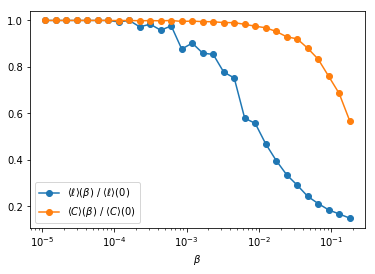

In [31]:
relat_av_l = [ell/av_l[0] for ell in av_l];
relat_av_c = [clust/av_clust[0] for clust in av_clust];
plt.clf();
plt.semilogx(beta_list,relat_av_l,'-o',label = r'$\left< \ell\right>(\beta)$ / $\left< \ell\right>(0)$');
plt.semilogx(beta_list,relat_av_c,'-o', label = r'$\left< C\right>(\beta)$ / $\left< C\right>(0)$');
plt.legend();
plt.xlabel(r'$\beta$')
plt.show();